# Overview

- [Dataset describtion](#Dataset-describtion)
- [Code description](#Code-description)
  - [Import necessary module](#Import-necessary-module)
  - [Function Definition](#Function-Definition)
- [Load data from csv file](#Load-data-from-csv-file)
  - [Convert categorical data to numerical data](#Convert-categorical-data-to-numerical-data)
  - [Adjust the special value](#Adjust-the-special-value)
  - [Partitioning a dataset into a seperate training and test set](#Partitioning-a-dataset-into-a-seperate-training-and-test-set)
- [Normalization and standardization](#Normalization-andstandardization)
- [Features Selection](#Features-Selection)
  - [Sparse solutions with L2 or L1 regularization](#Sparse-solutions-with-L2-or-L1-regularization)
  - [Sequential feature selection algorithms](#Sequential-feature-selection-algorithms)
  - [Assessing feature importance with Random Forests](#Assessing-feature-importance-with-Random-Forests)
- [Use different ML methods to train the data](#Use-different-ML-methods-to-train-the-data)
- [Better model in the same number of features](#Better-model-in-the-same-number-of-features) 
  - [Model using all the data](#Model-using-all-the-data)
  - [Model using only three features](#Model-using-only-three-features)
  - [Model using only two features](#Model-using-only-two-features)
  - [Model using only the best combined features](#Model-using-only-the-best-combined-features)
  - [Plot the results of two features](#Plot-the-results-of-two-features)
- [Summary](#Summary)

# Dataset describtion
# Input variables:

## bank client data:
   * 1 - age (numeric)
   * 2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
   * 3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
   * 4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
   * 5 - default: has credit in default? (categorical: "no","yes","unknown")
   * 6 - balance: average yearly balance, in euros (numeric)
   * 7 - housing: has housing loan? (categorical: "no","yes","unknown")
   * 8 - loan: has personal loan? (categorical: "no","yes","unknown")
   
## related with the last contact of the current campaign:
   * 9 - contact: contact communication type (categorical: "cellular","telephone") 
   * 10 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   * 11 - day: last contact day of the month (numeric)
   * 12 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
   
## other attributes:
  * 13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  * 14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  * 15 - previous: number of contacts performed before this campaign and for this client (numeric)
  * 16 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")


# Output variable (desired target):
  * 17 - y - has the client subscribed a term deposit? (binary: "yes","no")

# Code description
* Python 2.7 is required

# Import necessary module

In [1]:
# import the required Python mudule
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Function Definition

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

# Load data from csv file

In [2]:
df = pd.read_csv('bank.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


## Convert categorical data to numerical data

In [3]:
# first encode the label data
# create a mapping dict
# to convert label from strings to integers

y_mapping = {label: idx for idx, label in enumerate(np.unique(df['y']))}
df['y'] = df['y'].map(y_mapping)


In [4]:
# second convert category data from strings to integers
job_mapping = {label: idx for idx, label in enumerate(np.unique(df['job']))}
df['job'] = df['job'].map(job_mapping)

marital_mapping = {label: idx for idx, label in enumerate(np.unique(df['marital']))}
df['marital'] = df['marital'].map(marital_mapping)

education_mapping = {label: idx for idx, label in enumerate(np.unique(df['education']))}
df['education'] = df['education'].map(education_mapping)

default_mapping = {label: idx for idx, label in enumerate(np.unique(df['default']))}
df['default'] = df['default'].map(default_mapping)

housing_mapping = {label: idx for idx, label in enumerate(np.unique(df['housing']))}
df['housing'] = df['housing'].map(housing_mapping)

loan_mapping = {label: idx for idx, label in enumerate(np.unique(df['loan']))}
df['loan'] = df['loan'].map(loan_mapping)

contact_mapping = {label: idx for idx, label in enumerate(np.unique(df['contact']))}
df['contact'] = df['contact'].map(contact_mapping)

month_mapping = {label: idx for idx, label in enumerate(np.unique(df['month']))}
df['month'] = df['month'].map(month_mapping)

poutcome_mapping = {label: idx for idx, label in enumerate(np.unique(df['poutcome']))}
df['poutcome'] = df['poutcome'].map(poutcome_mapping)


### Adjust the special value
* pdays: -1 means client was not previously contacted
* covert -1 to 0

In [5]:
df.loc[df['pdays'] == -1,'pdays'] = 0

In [6]:
df.tail(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4511,46,1,1,1,0,668,1,0,2,15,8,1263,2,0,0,3,1
4512,40,1,1,1,0,1100,1,0,2,29,8,660,2,0,0,3,0
4513,49,1,1,1,0,322,0,0,0,14,1,356,2,0,0,3,0
4514,38,1,1,1,0,1205,1,0,0,20,0,45,4,153,1,0,0
4515,32,7,2,1,0,473,1,0,0,7,5,624,5,0,0,3,0
4516,33,7,1,1,0,-333,1,0,0,30,5,329,5,0,0,3,0
4517,57,6,1,2,1,-3313,1,1,2,9,8,153,1,0,0,3,0
4518,57,9,1,1,0,295,0,0,0,19,1,151,11,0,0,3,0
4519,28,1,1,1,0,1137,0,0,0,6,3,129,4,211,3,1,0
4520,44,2,2,2,0,1136,1,1,0,3,0,345,2,249,7,1,0


### Partitioning a dataset into a seperate training and test set

In [7]:
from sklearn.model_selection import train_test_split

X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

###  Normalization and standardization

In [8]:
# three diffrent methods
#- MinMaxScaler
#- StandardScaler N(0,1)
#- RobustScaler avoid outliers.

#- X_test's standardization should use the mean and std of X_train

def MinMaxNorm(X_train,X_test):
    from sklearn.preprocessing import MinMaxScaler

    mms = MinMaxScaler().fit(X_train)
    X_train_norm = mms.transform(X_train)
    X_test_norm = mms.transform(X_test)
    return X_train_norm,X_test_norm

def StdNorm(X_train,X_test):
    from sklearn.preprocessing import StandardScaler

    stdsc = StandardScaler().fit(X_train)
    X_train_std = stdsc.transform(X_train)
    X_test_std = stdsc.transform(X_test)
    return X_train_std,X_test_std

def RobustNorm(X_train,X_test):
    from sklearn.preprocessing import RobustScaler

    rbs = RobustScaler().fit(X_train)
    X_train_std = rbs.transform(X_train)
    X_test_std = rbs.transform(X_test)
    return X_train_std,X_test_std

# Here you can select the function of standardization and normalization

In [9]:
# get data after standardization and normalization
#X_train_std, X_test_std = RobustNorm(X_train, X_test)
X_train_std, X_test_std = StdNorm(X_train, X_test)
#X_train_std, X_test_std = MinMaxNorm(X_train, X_test)

# Features Selection

# Sparse solutions with L2 or L1 regularization

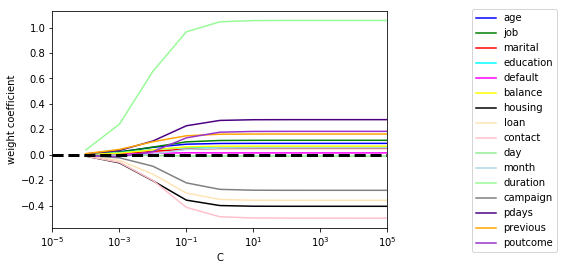

In [10]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black','moccasin' ,
          'pink', 'lightgreen', 'lightblue', 'palegreen',
          'gray', 'indigo','orange','darkorchid',
         'darkslategray','floralwhite','indigo','mediumorchid']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l2', C=10.**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[0])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df.columns[column],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
#plt.savefig('images/04_07.png', dpi=300, 
#            bbox_inches='tight', pad_inches=0.2)
plt.show()

# Assessing feature importance with Random Forests

 1) duration                       0.298562
 2) balance                        0.108035
 3) age                            0.104850
 4) day                            0.090323
 5) month                          0.080781
 6) job                            0.052704
 7) pdays                          0.050281
 8) poutcome                       0.041758
 9) campaign                       0.039676
10) education                      0.029596
11) marital                        0.025816
12) previous                       0.023577
13) housing                        0.022064
14) contact                        0.020217
15) loan                           0.009325
16) default                        0.002434


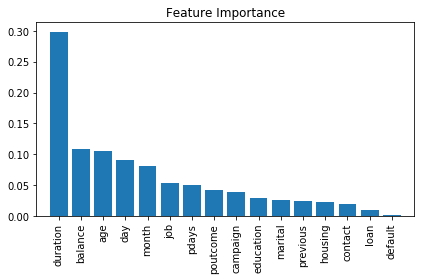

In [28]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df.columns[0:-1]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()

# Sequential feature selection algorithms
* I use Sequential Backward Selection (SBS) to select features
* We can outline the algorithm in 4 simple steps:
    * Initialize the algorithm with k=d  , where d is the dimensionality of the full feature space X_d .
    2. Determine the feature x− that maximizes the criterion x− = argmaxJ (X_k − x ) where x∈X_k .
    3. Remove the feature x− from the feature set: X_k – 1 = X_k-1 , = X_x − X,k= k −1.
    4. Terminate if k equals the number of desired features, if not, go to step 2.

In [11]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# defination of class of SBS
class SBS():
    def __init__(self, estimator, k_features,scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        self.df = df

    # self.subsets_ save all the best features under specific # of features
    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            
            self.scores_.append(scores[best])
            
            print '# of features：',dim
            print 'best scores is:',scores[best]
            dim -= 1

        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

# Use different ML methods to train the data
* LogisticRegression
* DecisionTreeClassifier
* RandomForestClassifier
* MLPClassifier
* KNeighborsClassifier
* SVM

# of features： 15
best scores is: 0.9026548672566371
# of features： 14
best scores is: 0.9039190897597977
# of features： 13
best scores is: 0.9026548672566371
# of features： 12
best scores is: 0.8988621997471555
# of features： 11
best scores is: 0.9064475347661188
# of features： 10
best scores is: 0.9026548672566371
# of features： 9
best scores is: 0.9039190897597977
# of features： 8
best scores is: 0.9013906447534766
# of features： 7
best scores is: 0.9026548672566371
# of features： 6
best scores is: 0.9039190897597977
# of features： 5
best scores is: 0.9039190897597977
# of features： 4
best scores is: 0.9039190897597977
# of features： 3
best scores is: 0.9026548672566371
# of features： 2
best scores is: 0.9026548672566371
# of features： 1
best scores is: 0.9039190897597977


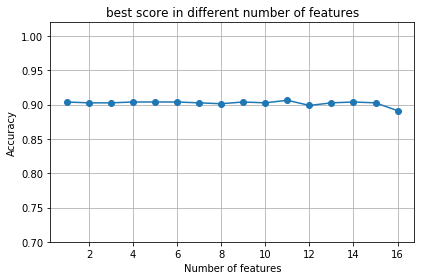

In [12]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Here you can select diferent method to do the training

#knn = KNeighborsClassifier(n_neighbors=2)
#knn = LogisticRegression(penalty='l2', C=10.**2, random_state=0)
knn = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=10, alpha=1e-4,
                    solver='sgd', activation='relu',verbose=False, tol=1e-4, random_state=1,learning_rate_init=.01)
#knn = svm.SVC(kernel='rbf', C=10)
#knn = RandomForestClassifier(n_estimators=10,random_state=1)
#knn = DecisionTreeClassifier()

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.title('best score in different number of features')
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

### List all the best selected features under a certain number of features

In [13]:
for i in sbs.subsets_:
    k = list(i)
    print 'When select ',len(k),'features, the best features as following'
    print df.columns[0:][k].values
    print ''

When select  16 features, the best features as following
['age' 'job' 'marital' 'education' 'default' 'balance' 'housing' 'loan'
 'contact' 'day' 'month' 'duration' 'campaign' 'pdays' 'previous'
 'poutcome']

When select  15 features, the best features as following
['job' 'marital' 'education' 'default' 'balance' 'housing' 'loan'
 'contact' 'day' 'month' 'duration' 'campaign' 'pdays' 'previous'
 'poutcome']

When select  14 features, the best features as following
['job' 'marital' 'education' 'default' 'balance' 'housing' 'loan' 'day'
 'month' 'duration' 'campaign' 'pdays' 'previous' 'poutcome']

When select  13 features, the best features as following
['job' 'marital' 'education' 'default' 'balance' 'housing' 'loan' 'day'
 'month' 'duration' 'campaign' 'pdays' 'poutcome']

When select  12 features, the best features as following
['job' 'marital' 'education' 'default' 'balance' 'housing' 'loan' 'day'
 'month' 'duration' 'campaign' 'poutcome']

When select  11 features, the best feature

# Better model in the same number of features

# Model using all features

In [14]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

('Training accuracy:', 0.8900126422250316)
('Test accuracy:', 0.8887251289609432)


# Model using only three features

In [25]:
k3 = list(sbs.subsets_[13])
print 'Features:',df.columns[0:][k3].values
knn.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Features: ['marital' 'balance' 'duration']
('Training accuracy:', 0.8890644753476612)
('Test accuracy:', 0.8843036109064112)


# Model using only two features

In [32]:
k2 = list(sbs.subsets_[14])
print 'Features:',df.columns[0:][k2].values
knn.fit(X_train_std[:, k2], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k2], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k2], y_test))

Features: ['marital' 'duration']
('Training accuracy:', 0.8890644753476612)
('Test accuracy:', 0.8850405305821666)


# Model using only the best combined features

In [27]:
best_idx = np.argmax(sbs.scores_)
k_best = list(sbs.subsets_[best_idx])
print 'Features:',df.columns[0:][k_best].values
knn.fit(X_train_std[:, k_best], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k_best], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k_best], y_test))

Features: ['job' 'marital' 'default' 'balance' 'housing' 'loan' 'day' 'month'
 'duration' 'campaign' 'poutcome']
('Training accuracy:', 0.893173198482933)
('Test accuracy:', 0.8857774502579219)


# Plot the results of two features

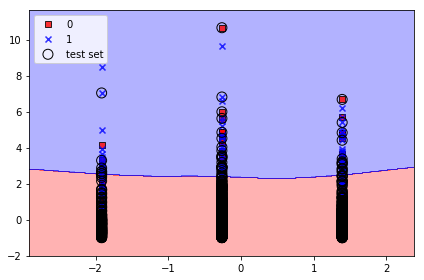

In [39]:
X_combined_std = np.vstack((X_train_std[:, k2], X_test_std[:, k2]))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std, y=y_combined,test_idx=range(int(0.7*len(y_combined)), len(y_combined)),
                      classifier=knn)

plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_14.png', dpi=300)
plt.show()

# Summary